In [28]:
# import environment
from marketsai.mon_policy.env_mon_fin_dictob import MonPolicyFinite

# from marketsai.mon_policy.env_mon_policy_colab import MonPolicyColab

# import ray
from ray import tune, shutdown, init
from ray.tune.registry import register_env

# from ray.tune.integration.mlflow import MLflowLoggerCallback

# For custom metrics (Callbacks)
from scipy.stats import linregress
from ray.rllib.agents.callbacks import DefaultCallbacks
from scipy.stats import linregress
from ray.rllib.env import BaseEnv
from ray.rllib.evaluation import MultiAgentEpisode, RolloutWorker
from ray.rllib.policy import Policy
from ray.rllib.agents.ppo import PPOTrainer

# common imports
from typing import Dict
import numpy as np
import seaborn as sn
import sys
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import json
import math
import random


""" STEP 0: Experiment configs """

DATE = "Dec28_"
ENV_LABEL = "mon_fin_FCC_lgscale"
OBS_IDSHOCK = False
INFL_REGIME = "low"
NATIVE = False
TEST = False
RUN_TRAINING = True
RUN_ANALYSIS = True
# in case there is no training
INFO_ANALYSIS = "/Users/matiascovarrubias/Dropbox/RL_macro/Tests/expINFO_native_mon_fin_exp_0_Nov1_PPO_test.json"
SAVE_EXP_INFO = True
SAVE_PROGRESS = True
PLOT_PROGRESS = True
sn.color_palette("Set2")


n_firms_LIST = [2]  # list with number of agents for each run
n_inds_LIST = [50]
ITERS_TEST = 10  # number of iteration for test
ITERS_RUN = 2000  # number of iteration for fullrun

# Other economic Hiperparameteres.
ENV_HORIZON = 12 * 3
EVAL_HORIZON = 12 * 3
BETA = 0.95 ** (1 / 12)  # discount parameter
MARKUP_RANGE = [1, 2.5]
NUM_POLICY = 2
NO_FLEX_HORIZON = 12 * 2
EVAL_RESULTS = True
""" STEP 1: Paralleliztion and batch options"""
# Parallelization options
NUM_CPUS = 10
NUM_CPUS_DRIVER = 1
NUM_TRIALS = 10
NUM_PAR_TRIALS = 10
NUM_ROLLOUT = ENV_HORIZON * 5
NUM_ENV_PW = 1  # num_env_per_worker
NUM_GPUS = 0
BATCH_ROLLOUT = 1
NUM_MINI_BATCH = NUM_CPUS_DRIVER

N_WORKERS = (NUM_CPUS - NUM_PAR_TRIALS * NUM_CPUS_DRIVER) // NUM_PAR_TRIALS
BATCH_SIZE = NUM_ROLLOUT * (max(N_WORKERS, 1)) * NUM_ENV_PW * BATCH_ROLLOUT

print("number of workers:", N_WORKERS, "batch size:", BATCH_SIZE)

# define length of experiment (MAX_STEPS) and experiment name
if TEST == True:
    MAX_STEPS = ITERS_TEST * BATCH_SIZE
else:
    MAX_STEPS = ITERS_RUN * BATCH_SIZE

# checkpointing, evaluation during trainging and stopage
CHKPT_FREQ = 1000
if TEST:
    EVAL_INTERVAL = ITERS_TEST
    EVAL_EPISODES = 1
    SIMUL_EPISODES = 1
else:
    EVAL_INTERVAL = 100
    EVAL_EPISODES = 10
    SIMUL_EPISODES = 100

STOP = {"timesteps_total": MAX_STEPS}

""" Environment configuration """

# environment config including evaluation environment (without exploration)
env_config = {
    "horizon": ENV_HORIZON,
    "n_inds": n_inds_LIST[0],
    "n_firms": n_firms_LIST[0],
    "markup_min": MARKUP_RANGE[0],
    "markup_max": MARKUP_RANGE[1],
    # "eval_mode": False,
    # "random_eval": True,
    # "analysis_mode": False,
    "noagg": False,
    "obs_flex_index": True,
    "obs_idshock": OBS_IDSHOCK,
    "infl_regime": INFL_REGIME,
    # "infl_regime_scale": [3, 1.3, 2],
}


env_config_eval = env_config.copy()
env_config_eval["eval_mode"] = True
# env_config_eval["random_eval"] = False
env_config_eval["horizon"] = EVAL_HORIZON


""" Custom metrics to pass to the algo configuration """
# Define custom metrics using the Callbacks class
# See rllib documentation on Callbacks. They are a way of inserting code in different parts of the pipeline.

# function to get discounted rewards for analysys
def process_rewards(r):
    """Compute discounted reward from a vector of rewards."""
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, len(r))):
        running_add = running_add * BETA + r[t]
        discounted_r[t] = running_add
    return discounted_r[0]


class MyCallbacks(DefaultCallbacks):
    def on_episode_start(
        self,
        *,
        worker: RolloutWorker,
        base_env: BaseEnv,
        policies: Dict[str, Policy],
        episode: MultiAgentEpisode,
        env_index: int,
        **kwargs,
    ):
        # Make sure this episode has just been started (only initial obs
        # logged so far).

        assert episode.length == 0, (
            "ERROR: `on_episode_start()` callback should be called right "
            "after env reset!"
        )
        episode.user_data["rewards"] = []
        episode.user_data["markup_ij_avge"] = []
        episode.user_data["markup_agg"] = []
        episode.user_data["freq_p_adj"] = []
        episode.user_data["size_adj"] = []
        episode.user_data["log_c"] = []
        episode.user_data["profits"] = []

    def on_episode_step(
        self,
        *,
        worker: RolloutWorker,
        base_env: BaseEnv,
        episode: MultiAgentEpisode,
        env_index: int,
        **kwargs,
    ):
        if episode.length > 1:  # at t=0, previous rewards are not defined
            episode.user_data["rewards"].append(episode.prev_reward_for(0))

            episode.user_data["markup_ij_avge"].append(
                episode.last_info_for(0)["mean_mu_ij"]
            )
            episode.user_data["markup_agg"].append(episode.last_info_for(0)["mu"])
            episode.user_data["freq_p_adj"].append(
                episode.last_info_for(0)["move_freq"]
            )
            episode.user_data["size_adj"].append(
                episode.last_info_for(0)["mean_p_change"]
            )
            episode.user_data["log_c"].append(episode.last_info_for(0)["log_c"])
            episode.user_data["profits"].append(
                episode.last_info_for(0)["mean_profits"]
            )

    def on_episode_end(
        self,
        *,
        worker: RolloutWorker,
        base_env: BaseEnv,
        policies: Dict[str, Policy],
        episode: MultiAgentEpisode,
        env_index: int,
        **kwargs,
    ):
        episode.custom_metrics["discounted_rewards"] = process_rewards(
            episode.user_data["rewards"][:-NO_FLEX_HORIZON]
        )

        episode.custom_metrics["mean_markup_ij"] = np.mean(
            episode.user_data["markup_ij_avge"][:-NO_FLEX_HORIZON]
        )
        episode.custom_metrics["mean_mu_agg"] = np.mean(
            episode.user_data["markup_agg"][:-NO_FLEX_HORIZON]
        )

        episode.custom_metrics["freq_p_adj"] = np.mean(
            episode.user_data["freq_p_adj"][:-NO_FLEX_HORIZON]
        )
        episode.custom_metrics["size_adj"] = np.mean(
            episode.user_data["size_adj"][:-NO_FLEX_HORIZON]
        )
        episode.custom_metrics["std_log_c"] = np.std(
            episode.user_data["log_c"][:-NO_FLEX_HORIZON]
        )
        episode.custom_metrics["profits"] = np.mean(
            episode.user_data["profits"][:-NO_FLEX_HORIZON]
        )

        episode.custom_metrics["mean_markup_ij_final"] = np.mean(
            episode.user_data["markup_ij_avge"][-12:]
        )


""" Algorithm configuration """

# we instantiate the environment to extrac relevant info
" CHANGE HERE "
env = MonPolicyFinite(env_config)

# common configuration

"""
NOTE: in order to do hyperparameter optimization, you can select a range of values 
with tune.choice([0.05,1] for random choice or tune.grid_search([0.05,1]) for fix search.
# see https://docs.ray.io/en/master/tune/key-concepts.html#search-spaces for spaces and their definition.
# se at the bottom (Annex_env_hyp) for an explanation how to do the same with environment parameters.
"""
common_config = {
    # CUSTOM METRICS
    "callbacks": MyCallbacks,
    # ENVIRONMENT
    "gamma": BETA,
    "env": ENV_LABEL,
    "env_config": env_config,
    "horizon": ENV_HORIZON,
    # MODEL
    "framework": "torch",
    "model": {
        "fcnet_hiddens": [128, 128, 128],
    },
    # "model": tune.grid_search([{"use_lstm": True}, {"use_lstm": False}]),
    # TRAINING CONFIG
    "num_workers": N_WORKERS,
    "create_env_on_driver": False,
    "num_gpus": NUM_GPUS / NUM_PAR_TRIALS,
    "num_envs_per_worker": NUM_ENV_PW,
    "num_cpus_for_driver": NUM_CPUS_DRIVER,
    "rollout_fragment_length": NUM_ROLLOUT,
    "train_batch_size": BATCH_SIZE,
    # EVALUATION
    "evaluation_interval": EVAL_INTERVAL,
    "evaluation_num_episodes": EVAL_EPISODES,
    "evaluation_config": {
        "explore": False,
        "env_config": env_config_eval,
    },
    # MULTIAGENT,
    "multiagent": {
        "policies": {
            f"policy_{i}": (
                None,
                env.observation_space[0],
                env.action_space[0],
                {},
            )
            for i in range(NUM_POLICY)
        },
        "policy_mapping_fn": (lambda agent_id: f"policy_{agent_id%NUM_POLICY}"),
        # "replay_mode": "independent",  # you can change to "lockstep".
        # OTHERS
    },
}

# Configs specific to the chosel algorithms, INCLUDING THE LEARNING RATE
ppo_config = {
    # "lr": 0.0001,
    "lr_schedule": [[0, 0.0007], [MAX_STEPS / 3, 0.00001]],
    "sgd_minibatch_size": BATCH_SIZE // NUM_MINI_BATCH,
    "num_sgd_iter": 1,
    "batch_mode": "complete_episodes",
    "lambda": 0.98,
    # "entropy_coeff": 0,
    # "kl_coeff": 0.2,
    # "vf_loss_coeff": 0.5,
    "vf_clip_param": float("inf"),
    # "entropy_coeff_schedule": [[0, 0.01], [5120 * 1000, 0]],
    "clip_param": 0.15,
    "clip_actions": True,
}

sac_config = {"prioritized_replay": False, "normalize_actions": False}

ALGO = "PPO"  # either PPO" or "SAC"
if NATIVE:
    device = "native_"  # either "native" or "server"
else:
    device = "server_"


if ALGO == "PPO":
    training_config = {**common_config, **ppo_config}
elif ALGO == "SAC":
    training_config = {**common_config, **sac_config}
else:
    training_config = common_config

# Define output folders
if TEST:
    if NATIVE:
        OUTPUT_PATH_EXPERS = (
            "/Users/matiascovarrubias/Dropbox/RL_macro/Experiments/ALL/"
        )
        OUTPUT_PATH_FIGURES = (
            "/Users/matiascovarrubias/Dropbox/RL_macro/Documents/Figures/ALL/"
        )
        OUTPUT_PATH_RESULTS = "~/ray_results/ALL/"
    else:
        OUTPUT_PATH_EXPERS = "/scratch/mc5851/Experiments/ALL/"
        OUTPUT_PATH_FIGURES = "/scratch/mc5851/Figures/ALL/"
        OUTPUT_PATH_RESULTS = "/scratch/mc5851/ray_results/ALL/"

else:
    if NATIVE:
        OUTPUT_PATH_EXPERS = "/Users/matiascovarrubias/Dropbox/RL_macro/Experiments/"
        OUTPUT_PATH_FIGURES = (
            "/Users/matiascovarrubias/Dropbox/RL_macro/Documents/Figures/"
        )
        OUTPUT_PATH_RESULTS = "~/ray_results"
    else:
        OUTPUT_PATH_EXPERS = "/scratch/mc5851/Experiments/"
        OUTPUT_PATH_FIGURES = "/scratch/mc5851/Figures/"
        OUTPUT_PATH_RESULTS = "/scratch/mc5851/ray_results/"

# Initialize ray
shutdown()
init(
    num_cpus=11,
    num_gpus=NUM_GPUS,
    log_to_driver=False,
)
# global configss
register_env(ENV_LABEL, MonPolicyFinite)

number of workers: 0 batch size: 180


/scratch/mc5851/.cache/pypoetry/virtualenvs/marketsai-yL5UKpPI-py3.8/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


In [29]:
""" STEP 4: run training """

if RUN_TRAINING:
    exp_names = []
    trial_logdirs = []
    exp_dirs = []
    checkpoints = []
    configs = []

    rewards_eval = []
    mu_ij_eval = []
    mu_agg_eval = []
    mu_ij_final_eval = []
    freq_p_adj_eval = []
    size_adj_eval = []
    std_log_c_eval = []
    profits_eval = []

    rewards = []
    mu_ij = []
    mu_agg = []
    mu_ij_final = []
    freq_p_adj = []
    size_adj = []
    std_log_c = []
    profits = []

    # RUN TRAINER
    env_configs = []

    EXP_LABEL = device + ENV_LABEL + f"_exp_"
    if TEST == True:
        EXP_NAME = EXP_LABEL + DATE + ALGO + "_test"
    else:
        EXP_NAME = EXP_LABEL + DATE + ALGO + "_run"

    analysis = tune.run(
        ALGO,
        name=EXP_NAME,
        config=training_config,
        stop=STOP,
        checkpoint_freq=CHKPT_FREQ,
        checkpoint_at_end=True,
        # metric="evaluation/custom_metrics/discounted_rewards_mean",
        # metric="custom_metrics/discounted_rewards_mean",
        # mode="max",
        num_samples=NUM_TRIALS,
        local_dir=OUTPUT_PATH_RESULTS,
        verbose=1,
        # resources_per_trial={"gpu": 0.5},
    )

    rewards_eval.append(
        [
            list(analysis.results.values())[i]["evaluation"]["custom_metrics"][
                "discounted_rewards_mean"
            ]
            for i in range(NUM_TRIALS)
        ]
    )
    mu_ij_eval.append(
        [
            list(analysis.results.values())[i]["evaluation"]["custom_metrics"][
                "mean_markup_ij_mean"
            ]
            for i in range(NUM_TRIALS)
        ]
    )
    mu_agg_eval.append(
        [
            list(analysis.results.values())[i]["evaluation"]["custom_metrics"][
                "mean_mu_agg_mean"
            ]
            for i in range(NUM_TRIALS)
        ]
    )
    mu_ij_final_eval.append(
        [
            list(analysis.results.values())[i]["evaluation"]["custom_metrics"][
                "mean_markup_ij_final_mean"
            ]
            for i in range(NUM_TRIALS)
        ]
    )
    freq_p_adj_eval.append(
        [
            list(analysis.results.values())[i]["evaluation"]["custom_metrics"][
                "freq_p_adj_mean"
            ]
            for i in range(NUM_TRIALS)
        ]
    )
    size_adj_eval.append(
        [
            list(analysis.results.values())[i]["evaluation"]["custom_metrics"][
                "size_adj_mean"
            ]
            for i in range(NUM_TRIALS)
        ]
    )

    std_log_c_eval.append(
        [
            list(analysis.results.values())[i]["evaluation"]["custom_metrics"][
                "std_log_c_mean"
            ]
            for i in range(NUM_TRIALS)
        ]
    )

    profits_eval.append(
        [
            list(analysis.results.values())[i]["custom_metrics"]["profits_mean"]
            for i in range(NUM_TRIALS)
        ]
    )
    rewards.append(
        [
            list(analysis.results.values())[i]["custom_metrics"][
                "discounted_rewards_mean"
            ]
            for i in range(NUM_TRIALS)
        ]
    )
    mu_ij.append(
        [
            list(analysis.results.values())[i]["custom_metrics"]["mean_markup_ij_mean"]
            for i in range(NUM_TRIALS)
        ]
    )
    mu_agg.append(
        [
            list(analysis.results.values())[i]["custom_metrics"]["mean_mu_agg_mean"]
            for i in range(NUM_TRIALS)
        ]
    )
    mu_ij_final.append(
        [
            list(analysis.results.values())[i]["custom_metrics"][
                "mean_markup_ij_final_mean"
            ]
            for i in range(NUM_TRIALS)
        ]
    )
    freq_p_adj.append(
        [
            list(analysis.results.values())[i]["custom_metrics"]["freq_p_adj_mean"]
            for i in range(NUM_TRIALS)
        ]
    )
    size_adj.append(
        [
            list(analysis.results.values())[i]["custom_metrics"]["size_adj_mean"]
            for i in range(NUM_TRIALS)
        ]
    )

    std_log_c.append(
        [
            list(analysis.results.values())[i]["custom_metrics"]["std_log_c_mean"]
            for i in range(NUM_TRIALS)
        ]
    )

    profits.append(
        [
            list(analysis.results.values())[i]["custom_metrics"]["profits_mean"]
            for i in range(NUM_TRIALS)
        ]
    )
    exp_names.append(EXP_NAME)
    exp_dirs.append(analysis._experiment_dir)
    trial_logdirs.append([analysis.trials[i].logdir for i in range(NUM_TRIALS)])
    configs.append(
        [
            {
                "env_config": analysis.trials[i].config["env_config"],
                # "lr": analysis.trials[i].config["lr"],
                "lr_schedule": analysis.trials[i].config["lr_schedule"],
            }
            for i in range(NUM_TRIALS)
        ]
    )
    checkpoints.append([analysis.trials[i].checkpoint.value for i in range(NUM_TRIALS)])

    # learning_dta.append(
    #     analysis.best_dataframe[
    #         ["episodes_total", "evaluation/custom_metrics/discounted_rewards_mean"]
    #     ]
    # )

    # global experiment name
if len(exp_names) > 1:
    EXP_LABEL = device + f"_multiexp_"
    if TEST == True:
        EXP_NAME = EXP_LABEL + ENV_LABEL + "_test_" + DATE + ALGO
    else:
        EXP_NAME = EXP_LABEL + ENV_LABEL + "_run_" + DATE + ALGO

# create CSV with information on each experiment
exp_dict = {
    "n_agents": n_firms_LIST,
    "exp_names": exp_names,
    "exp_dirs": exp_dirs,
    "trial_dirs": trial_logdirs,
    "checkpoints": checkpoints,
    "configs": configs,
    "results_eval": [
        rewards_eval,
        mu_ij_eval,
        mu_agg_eval,
        mu_ij_final_eval,
        freq_p_adj_eval,
        size_adj_eval,
        std_log_c_eval,
        profits_eval,
    ],
    "results": [
        rewards,
        mu_ij,
        mu_agg,
        mu_ij_final,
        freq_p_adj,
        size_adj,
        std_log_c,
        profits,
    ],
}

# print(
#     "mu_ij",
#     mu_ij_eval,
#     "\n",
#     "mu_agg",
#     mu_agg_eval,
#     "\n",
#     "mu_ij_final",
#     mu_ij_final_eval,
#     "\n",
#     "freq_p_adj:",
#     freq_p_adj_eval,
#     "\n",
#     "size_adj",
#     size_adj_eval,
#     "\n",
#     "std_log_c:",
#     std_log_c_eval,
# )

with open(OUTPUT_PATH_EXPERS + "expINFO_" + EXP_NAME + ".json", "w+") as f:
    json.dump(exp_dict, f)

# exp_df = pd.DataFrame(exp_dict)
# exp_df.to_csv(OUTPUT_PATH_EXPERS + "exp_info" + EXP_NAME + ".csv")
print(OUTPUT_PATH_EXPERS + "expINFO_" + EXP_NAME + ".json")

# erase progress.csv
for i in range(NUM_TRIALS):
    os.remove(trial_logdirs[0][i] + "/progress.csv")

2021-12-28 18:00:08,516	INFO tune.py:630 -- Total run time: 6214.94 seconds (6214.24 seconds for the tuning loop).


/scratch/mc5851/Experiments/expINFO_server_mon_fin_FCC_lgscale_exp_Dec28_PPO_run.json


In [30]:
learning_dta = []

learning_dta.append(
    [
        list(analysis.trial_dataframes.values())[i][
            [
                # "episodes_total",
                "custom_metrics/discounted_rewards_mean",
                "custom_metrics/mean_markup_ij_mean",
                "custom_metrics/mean_mu_agg_mean",
                "custom_metrics/mean_markup_ij_final_mean",
                "custom_metrics/freq_p_adj_mean",
                "custom_metrics/size_adj_mean",
                "custom_metrics/std_log_c_mean",
                "custom_metrics/profits_mean",
            ]
        ]
        for i in range(NUM_TRIALS)
    ]
)
for i in range(NUM_TRIALS):
    learning_dta[0][i].columns = [
        # "episodes_total",
        f"discounted_rewards_trial_{i}",
        f"mu_ij_trial_{i}",
        f"mu_agg_trial_{i}",
        f"mu_ij_final_trial_{i}",
        f"freq_p_adj_trial_{i}",
        f"size_adj_trial_{i}",
        f"std_log_c_trial_{i}",
        f"profits_trial_{i}",
    ]
    # learning_dta[0][i].set_index("episodes_total")
learning_dta_concat = pd.concat(learning_dta[0], axis=1)
learning_stats_dta = pd.DataFrame()
learning_stats_dta["rewards_avge"] = learning_dta_concat[
    [f"discounted_rewards_trial_{i}" for i in range(NUM_TRIALS)]
].mean(axis=1)
learning_stats_dta["rewards_std"] = learning_dta_concat[
    [f"discounted_rewards_trial_{i}" for i in range(NUM_TRIALS)]
].std(axis=1)
learning_stats_dta["rewards_upper"] = (
    learning_stats_dta["rewards_avge"] + learning_stats_dta["rewards_std"]
)
learning_stats_dta["rewards_lower"] = (
    learning_stats_dta["rewards_avge"] - learning_stats_dta["rewards_std"]
)
learning_stats_dta["mu_ij_avge"] = learning_dta_concat[
    [f"mu_ij_trial_{i}" for i in range(NUM_TRIALS)]
].mean(axis=1)
learning_stats_dta["mu_ij_std"] = learning_dta_concat[
    [f"mu_ij_trial_{i}" for i in range(NUM_TRIALS)]
].std(axis=1)
learning_stats_dta["mu_ij_upper"] = (
    learning_stats_dta["mu_ij_avge"] + learning_stats_dta["mu_ij_std"]
)
learning_stats_dta["mu_ij_lower"] = (
    learning_stats_dta["mu_ij_avge"] - learning_stats_dta["mu_ij_std"]
)
learning_stats_dta["freq_p_adj_avge"] = learning_dta_concat[
    [f"freq_p_adj_trial_{i}" for i in range(NUM_TRIALS)]
].mean(axis=1)
learning_stats_dta["freq_p_adj_std"] = learning_dta_concat[
    [f"freq_p_adj_trial_{i}" for i in range(NUM_TRIALS)]
].std(axis=1)
learning_stats_dta["freq_p_adj_upper"] = (
    learning_stats_dta["freq_p_adj_avge"] + learning_stats_dta["freq_p_adj_std"]
)
learning_stats_dta["freq_p_adj_lower"] = (
    learning_stats_dta["freq_p_adj_avge"] - learning_stats_dta["freq_p_adj_std"]
)
learning_stats_dta["size_adj_avge"] = learning_dta_concat[
    [f"size_adj_trial_{i}" for i in range(NUM_TRIALS)]
].mean(axis=1)
learning_stats_dta["size_adj_std"] = learning_dta_concat[
    [f"size_adj_trial_{i}" for i in range(NUM_TRIALS)]
].std(axis=1)
learning_stats_dta["size_adj_upper"] = (
    learning_stats_dta["size_adj_avge"] + learning_stats_dta["size_adj_std"]
)
learning_stats_dta["size_adj_lower"] = (
    learning_stats_dta["size_adj_avge"] - learning_stats_dta["size_adj_std"]
)
learning_stats_dta["mu_flex_avge"] = learning_dta_concat[
    [f"mu_ij_final_trial_{i}" for i in range(NUM_TRIALS)]
].mean(axis=1)
learning_stats_dta["mu_flex_std"] = learning_dta_concat[
    [f"mu_ij_final_trial_{i}" for i in range(NUM_TRIALS)]
].std(axis=1)
learning_stats_dta["mu_flex_upper"] = (
    learning_stats_dta["mu_flex_avge"] + learning_stats_dta["mu_flex_std"]
)
learning_stats_dta["mu_flex_lower"] = (
    learning_stats_dta["mu_flex_avge"] - learning_stats_dta["mu_flex_std"]
)
learning_stats_dta["profits_avge"] = learning_dta_concat[
    [f"profits_trial_{i}" for i in range(NUM_TRIALS)]
].mean(axis=1)
learning_stats_dta["profits_std"] = learning_dta_concat[
    [f"profits_trial_{i}" for i in range(NUM_TRIALS)]
].std(axis=1)
learning_stats_dta["profits_upper"] = (
    learning_stats_dta["profits_avge"] + learning_stats_dta["profits_std"]
)
learning_stats_dta["profits_lower"] = (
    learning_stats_dta["profits_avge"] - learning_stats_dta["profits_std"]
)
learning_stats_dta.to_csv(OUTPUT_PATH_EXPERS + "progress_" + exp_names[0] + ".csv")
# erase from ram
learning_dta = []
learning_dta_concat = []
analysis = []

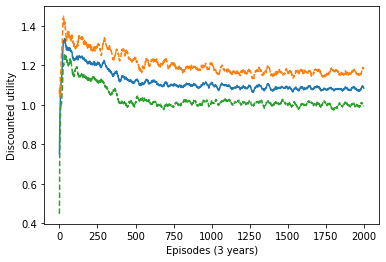

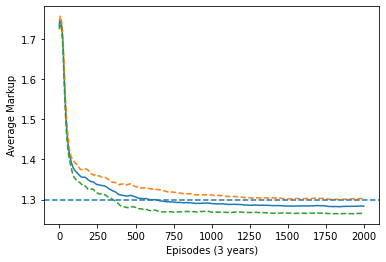

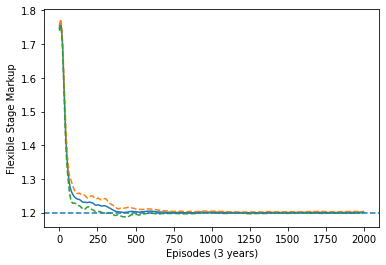

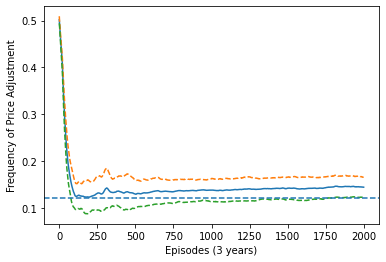

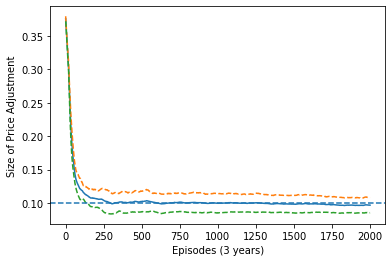

In [31]:
""" Organize and Plot multi firm expers """

# Plot and save progress

for ind, n_firms in enumerate(n_firms_LIST):
    learning_plot = sn.lineplot(
        data=learning_stats_dta,
        y="rewards_avge",
        x=learning_stats_dta.index,
    )
    learning_plot = sn.lineplot(
        data=learning_stats_dta,
        y="rewards_upper",
        x=learning_stats_dta.index,
        linestyle="--",
    )
    learning_plot = sn.lineplot(
        data=learning_stats_dta,
        y="rewards_lower",
        x=learning_stats_dta.index,
        linestyle="--",
    )
    learning_plot = learning_plot.get_figure()
    plt.ylabel("Discounted utility")
    plt.xlabel("Episodes (3 years)")
    learning_plot.savefig(
        OUTPUT_PATH_FIGURES + "progress_rewards" + exp_names[0] + ".png"
    )
    plt.show()
    plt.close()

    learning_plot = sn.lineplot(
        data=learning_stats_dta,
        y="mu_ij_avge",
        x=learning_stats_dta.index,
    )
    learning_plot = sn.lineplot(
        data=learning_stats_dta,
        y="mu_ij_upper",
        x=learning_stats_dta.index,
        linestyle="--",
    )
    learning_plot = sn.lineplot(
        data=learning_stats_dta,
        y="mu_ij_lower",
        x=learning_stats_dta.index,
        linestyle="--",
    )
    learning_plot = learning_plot.get_figure()
    plt.ylabel("Average Markup")
    plt.xlabel("Episodes (3 years)")
    plt.axhline(y=1.3, linestyle="--")
    learning_plot.savefig(
        OUTPUT_PATH_FIGURES + "progress_mu_ij" + exp_names[0] + ".png"
    )
    plt.show()
    plt.close()

    learning_plot = sn.lineplot(
        data=learning_stats_dta,
        y="mu_flex_avge",
        x=learning_stats_dta.index,
    )
    learning_plot = sn.lineplot(
        data=learning_stats_dta,
        y="mu_flex_upper",
        x=learning_stats_dta.index,
        linestyle="--",
    )
    learning_plot = sn.lineplot(
        data=learning_stats_dta,
        y="mu_flex_lower",
        x=learning_stats_dta.index,
        linestyle="--",
    )
    learning_plot = learning_plot.get_figure()
    plt.ylabel("Flexible Stage Markup")
    plt.xlabel("Episodes (3 years)")
    plt.axhline(y=1.2, linestyle="--")
    learning_plot.savefig(
        OUTPUT_PATH_FIGURES + "progress_mu_flex" + exp_names[0] + ".png"
    )
    plt.show()
    plt.close()

    learning_plot = sn.lineplot(
        data=learning_stats_dta,
        y="freq_p_adj_avge",
        x=learning_stats_dta.index,
    )
    learning_plot = sn.lineplot(
        data=learning_stats_dta,
        y="freq_p_adj_upper",
        x=learning_stats_dta.index,
        linestyle="--",
    )
    learning_plot = sn.lineplot(
        data=learning_stats_dta,
        y="freq_p_adj_lower",
        x=learning_stats_dta.index,
        linestyle="--",
    )
    learning_plot = learning_plot.get_figure()
    plt.ylabel("Frequency of Price Adjustment")
    plt.xlabel("Episodes (3 years)")
    plt.axhline(y=0.12, linestyle="--")
    learning_plot.savefig(
        OUTPUT_PATH_FIGURES + "progress_freq_p_adj" + exp_names[0] + ".png"
    )
    plt.show()
    plt.close()

    learning_plot = sn.lineplot(
        data=learning_stats_dta,
        y="size_adj_avge",
        x=learning_stats_dta.index,
    )
    learning_plot = sn.lineplot(
        data=learning_stats_dta,
        y="size_adj_upper",
        x=learning_stats_dta.index,
        linestyle="--",
    )
    learning_plot = sn.lineplot(
        data=learning_stats_dta,
        y="size_adj_lower",
        x=learning_stats_dta.index,
        linestyle="--",
    )
    learning_plot = learning_plot.get_figure()
    plt.ylabel("Size of Price Adjustment")
    plt.xlabel("Episodes (3 years)")
    plt.axhline(y=0.1, linestyle="--")
    learning_plot.savefig(
        OUTPUT_PATH_FIGURES + "progress_size_adj" + exp_names[0] + ".png"
    )
    plt.show()
    plt.close()

results_stats: {'Mean Markups': 1.2783114447159023, 'S.D. Markups': 0.016258943754586433, 'Mean Agg. Markups': 1.175193650482934, 'S.D. Agg. Markups': 0.013779388081100942, 'Mean Flexible Markups': 1.201253011661023, 'S.D. Flexible Markups': 0.002117357628133879, 'Mean Freq. of Adj.': 0.13789090909090912, 'S.D. Freq. of Adj.': 0.021172210072140388, 'Mean Size of Adj.': 0.08951897419924534, 'S.D. Size of Adj.': 0.009401474987175888, 'Mean S.D. of log C': 0.012948972917903558, 'S.D. S.D. of log C': 0.002123855703608598, 'Mean Profits': 0.09827821815994184, 'S.D. Profits': 0.004856602988291189}


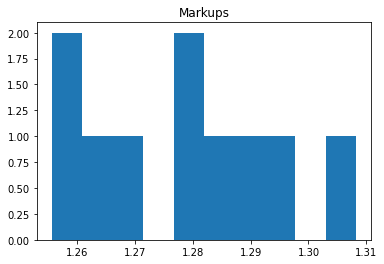

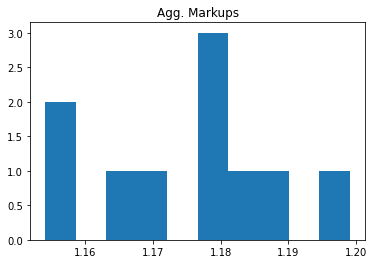

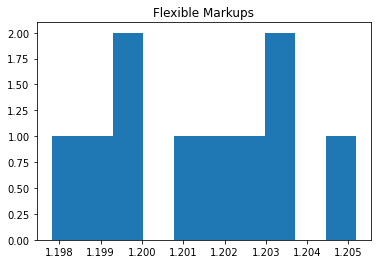

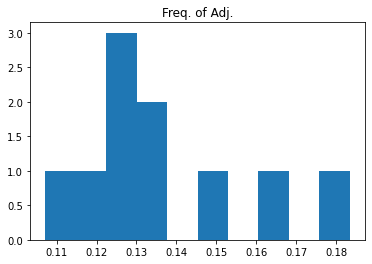

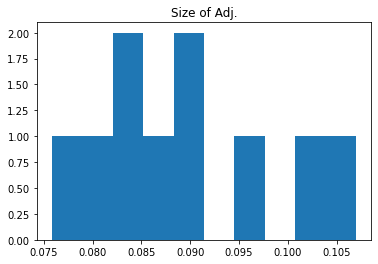

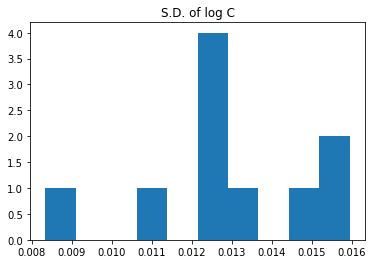

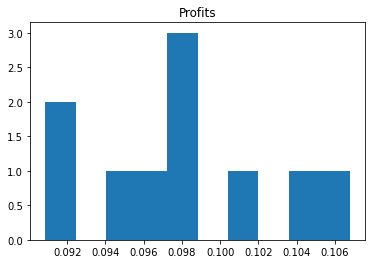

In [32]:
""" Step 5 Run Analysis """

if RUN_ANALYSIS:
    # If there is no training, import exp info
    if not RUN_TRAINING:
        with open(INFO_ANALYSIS) as f:
            exp_dict = json.load(f)
    # Choose weather you want leval results or live results
    if EVAL_RESULTS:
        results_data = exp_dict["results_eval"]
    else:
        results_data = exp_dict["results"]

    exp_names = exp_dict["exp_names"]
    checkpoints = exp_dict["checkpoints"][0]
    results = {
        "Markups": np.array(results_data[1][0]),
        "Agg. Markups": np.array(results_data[2][0]),
        "Flexible Markups": np.array(results_data[3][0]),
        "Freq. of Adj.": np.array(results_data[4][0]),
        "Size of Adj.": np.array(results_data[5][0]),
        "S.D. of log C": np.array(results_data[6][0]),
        "Profits": np.array(results_data[7][0]),
    }

    results_stats = {
        "Mean Markups": np.mean(results["Markups"]),
        "S.D. Markups": np.std(results["Markups"]),
        "Mean Agg. Markups": np.mean(results["Agg. Markups"]),
        "S.D. Agg. Markups": np.std(results["Agg. Markups"]),
        "Mean Flexible Markups": np.mean(results["Flexible Markups"]),
        "S.D. Flexible Markups": np.std(results["Flexible Markups"]),
        "Mean Freq. of Adj.": np.mean(results["Freq. of Adj."]),
        "S.D. Freq. of Adj.": np.std(results["Freq. of Adj."]),
        "Mean Size of Adj.": np.mean(results["Size of Adj."]),
        "S.D. Size of Adj.": np.std(results["Size of Adj."]),
        "Mean S.D. of log C": np.mean(results["S.D. of log C"]),
        "S.D. S.D. of log C": np.std(results["S.D. of log C"]),
        "Mean Profits": np.mean(results["Profits"]),
        "S.D. Profits": np.std(results["Profits"]),
    }

    print("results_stats:", results_stats)

    # Plot histograms
    for i, x in results.items():
        plt.hist(x)
        plt.title(i)
        plt.savefig(
            OUTPUT_PATH_FIGURES + "hist_" + f"{i}" + "_" + exp_names[0] + ".png"
        )
        plt.show()
        plt.close()

Selected chekpoint; [1.3082387276029952, 1.2051890598498285, 0.12872727272727275, 0.08710982325509738, 0.014550914977408305, 1.199105410663274]


/scratch/mc5851/.cache/pypoetry/virtualenvs/marketsai-yL5UKpPI-py3.8/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(
2021-12-28 18:00:41,460	WARNING trainer_template.py:185 -- `execution_plan` functions should accept `trainer`, `workers`, and `config` as args!
2021-12-28 18:00:41,461	WARNING deprecation.py:38 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future!
2021-12-28 18:00:41,487	WARNING util.py:57 -- Install gputil for GPU system monitoring.
2021-12-28 18:00:41,501	INFO trainable.py:416 -- Restored on 10.32.34.254 from checkpoint: /scratch/mc5851/ray_results/server_mon_fin_FCC_lgscale_exp_Dec28_PPO_run/PPO_mon_fin_FCC_lgscale_6ef87_00003_3_2021-12-28_16-16-36/checkpoint_002000/checkpoint-2000
2021-12-28 18:00:41,502	INFO trainable.py:424 -- Current state after restoring: {'_iteration': 2000, '_timesteps_total': 0, '_time_total': 5991.768513679504

[-0.6872671 -0.6932204]


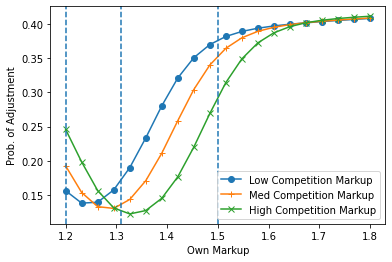

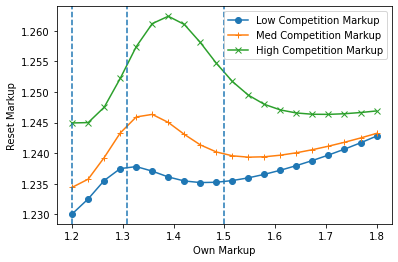

Slope of own react, low [0.5152450831873078, 0.012796635074274887]
Slope of own react, med [0.5506677978805135, 0.002699600798743112]
Slope of own react, high [0.5392970382457689, -0.011451745671885361]


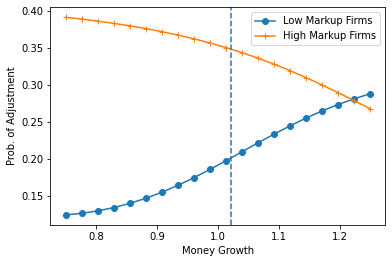

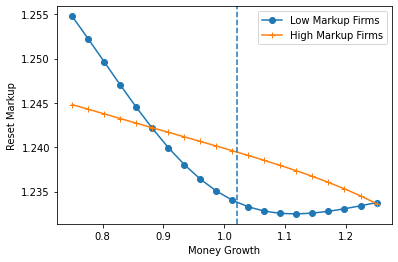

Slope to mon, low [0.36303541234561365, 0.36303541234561365]
Slope to mon, high [-0.2447157480887004, -0.021507605910301205]


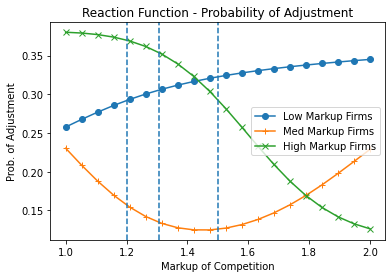

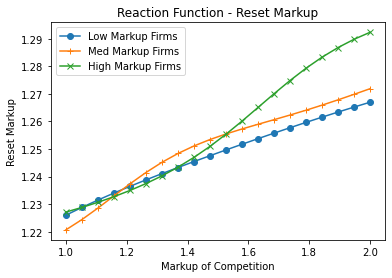

Slope of react, low [0.08202271695647921, 0.04055784663983754]
Slope of react, med [0.012188690049307676, 0.04899532965251376]
Slope of react, high [-0.2985684369291578, 0.07093145102262495]


In [33]:
""" Inspect Policy Functions for a given trial """

# Select trial to analyze
CHKPT_SELECT_REF = False
RESULTS_REF = np.array(
    [
        results_stats["Mean Markups"],
        results_stats["Mean Freq. of Adj."],
        results_stats["Mean Size of Adj."],
    ]
)
CHKPT_SELECT_MANUAL = False
CHKPT_id = 0
CHKPT_SELECT_MIN = False
CHKPT_SELECT_MAX = True

results_list = [
    [
        results["Markups"][i],
        results["Flexible Markups"][i],
        results["Freq. of Adj."][i],
        results["Size of Adj."][i],
        results["S.D. of log C"][i],
        results["Agg. Markups"][i],
    ]
    for i in range(NUM_TRIALS)
]
if CHKPT_SELECT_REF:

    distance_agg = np.array(
        [
            ((results["Markups"][i] - RESULTS_REF[0]) / results_stats["S.D. Markups"])
            ** 2
            + (
                (results["Freq. of Adj."][i] - RESULTS_REF[1])
                / results_stats["S.D. Freq. of Adj."]
            )
            ** 2
            + (
                (results["Size of Adj."][i] - RESULTS_REF[2])
                / results_stats["S.D. Size of Adj."]
            )
            ** 2
            for i in range(NUM_TRIALS)
        ]
    )

    selected_id = distance_agg.argmin()

if CHKPT_SELECT_MIN:
    selected_id = results["Markups"].argmin()

if CHKPT_SELECT_MAX:
    selected_id = results["Markups"].argmax()

if CHKPT_SELECT_MANUAL:
    selected_id = CHKPT_id

selected_stats = results_list[selected_id]
print("Selected chekpoint;", selected_stats)
INPUT_PATH_CHECKPOINT = checkpoints[selected_id]

shutdown()
init(
    num_cpus=11,
    log_to_driver=False,
)

# register environment
env_label = "mon_policy_finite"
register_env(env_label, MonPolicyFinite)
config_algo = training_config.copy()
config_algo["explore"] = False
trained_trainer = PPOTrainer(env=env_label, config=config_algo)
trained_trainer.restore(INPUT_PATH_CHECKPOINT)

""" Policy function with respect to own markup """

markup = [1.2 + (i / 19) * (0.6) for i in range(20)]
if not OBS_IDSHOCK:
    obs_reaction_lowmu = [
        {
            "obs_ind": np.array(
                [markup[i]] + [1.2 for i in range(n_firms_LIST[0] - 1)],
                dtype=np.float32,
            ),
            "obs_agg": np.array(
                [1.165, math.e ** env.params["log_g_bar"]], dtype=np.float32
            ),
            "time": 24,
            "flex_index": 0,
        }
        for i in range(20)
    ]
    obs_reaction_medmu = [
        {
            "obs_ind": np.array(
                [markup[i]] + [selected_stats[0] for i in range(n_firms_LIST[0] - 1)],
                dtype=np.float32,
            ),
            "obs_agg": np.array(
                [selected_stats[1], math.e ** env.params["log_g_bar"]], dtype=np.float32
            ),
            "time": 24,
            "flex_index": 0,
        }
        for i in range(20)
    ]
    obs_reaction_highmu = [
        {
            "obs_ind": np.array(
                [markup[i]] + [1.5 for i in range(n_firms_LIST[0] - 1)],
                dtype=np.float32,
            ),
            "obs_agg": np.array(
                [selected_stats[1], math.e ** env.params["log_g_bar"]], dtype=np.float32
            ),
            "time": 24,
            "flex_index": 0,
        }
        for i in range(20)
    ]
else:
    obs_reaction_lowmu = [
        {
            "obs_ind": np.array(
                [markup[i]]
                + [1.2 for i in range(n_firms_LIST[0] - 1)]
                + [1 for i in range(n_firms_LIST[0])],
                dtype=np.float32,
            ),
            "obs_agg": np.array(
                [selected_stats[1], math.e ** env.params["log_g_bar"]], dtype=np.float32
            ),
            "time": 24,
            "flex_index": 0,
        }
        for i in range(20)
    ]
    obs_reaction_medmu = [
        {
            "obs_ind": np.array(
                [markup[i]]
                + [selected_stats[0] for i in range(n_firms_LIST[0] - 1)]
                + [1 for i in range(n_firms_LIST[0])],
                dtype=np.float32,
            ),
            "obs_agg": np.array(
                [selected_stats[1], math.e ** env.params["log_g_bar"]], dtype=np.float32
            ),
            "time": 24,
            "flex_index": 0,
        }
        for i in range(20)
    ]
    obs_reaction_highmu = [
        {
            "obs_ind": np.array(
                [markup[i]]
                + [1.5 for i in range(n_firms_LIST[0] - 1)]
                + [1 for i in range(n_firms_LIST[0])],
                dtype=np.float32,
            ),
            "obs_agg": np.array(
                [selected_stats[1], math.e ** env.params["log_g_bar"]], dtype=np.float32
            ),
            "time": 24,
            "flex_index": 0,
        }
        for i in range(20)
    ]


actions_reaction_lowmu = [
    trained_trainer.compute_action(obs_reaction_lowmu[i], policy_id="policy_0")
    for i in range(20)
]
actions_reaction_medmu = [
    trained_trainer.compute_action(obs_reaction_medmu[i], policy_id="policy_0")
    for i in range(20)
]
actions_reaction_highmu = [
    trained_trainer.compute_action(obs_reaction_highmu[i], policy_id="policy_0")
    for i in range(20)
]

print(actions_reaction_lowmu[0])

move_prob_lowmu = [(actions_reaction_lowmu[i][0] + 1) / 2 for i in range(20)]
reset_lowmu = [
    MARKUP_RANGE[0]
    + (MARKUP_RANGE[1] - MARKUP_RANGE[0]) * (actions_reaction_lowmu[i][1] + 1) / 2
    for i in range(20)
]
move_prob_medmu = [(actions_reaction_medmu[i][0] + 1) / 2 for i in range(20)]
reset_medmu = [
    MARKUP_RANGE[0]
    + (MARKUP_RANGE[1] - MARKUP_RANGE[0]) * (actions_reaction_medmu[i][1] + 1) / 2
    for i in range(20)
]
move_prob_highmu = [(actions_reaction_highmu[i][0] + 1) / 2 for i in range(20)]
reset_highmu = [
    MARKUP_RANGE[0]
    + (MARKUP_RANGE[1] - MARKUP_RANGE[0]) * (actions_reaction_highmu[i][1] + 1) / 2
    for i in range(20)
]

x = markup
plt.plot(x, move_prob_lowmu, "-o")
plt.plot(x, move_prob_medmu, "-+")
plt.plot(x, move_prob_highmu, "-x")
plt.axvline(x=1.2, linestyle="--")
plt.axvline(x=selected_stats[0], linestyle="--")
plt.axvline(x=1.5, linestyle="--")
plt.legend(
    ["Low Competition Markup", "Med Competition Markup", "High Competition Markup"]
)
plt.xlabel("Own Markup")
plt.ylabel("Prob. of Adjustment")
# plt.title("Probability of Adjustment")
# plt.title("MIN")

plt.savefig(OUTPUT_PATH_FIGURES + "polown_prob_" + "_" + exp_names[0] + "_min" + ".png")
plt.show()
plt.close()

plt.plot(x, reset_lowmu, "-o")
plt.plot(x, reset_medmu, "-+")
plt.plot(x, reset_highmu, "-x")
plt.axvline(x=1.2, linestyle="--")
plt.axvline(x=selected_stats[0], linestyle="--")
plt.axvline(x=1.5, linestyle="--")
plt.legend(
    ["Low Competition Markup", "Med Competition Markup", "High Competition Markup"]
)
plt.xlabel("Own Markup")
plt.ylabel("Reset Markup")
# plt.title("Reset Markup")
# plt.title("MIN")
plt.savefig(
    OUTPUT_PATH_FIGURES + "polown_reset_" + "_" + exp_names[0] + "_min" + ".png"
)
plt.show()
plt.close()

reg_react_prob_low = linregress(markup, move_prob_lowmu)
reg_react_prob_med = linregress(markup, move_prob_medmu)
reg_react_prob_high = linregress(markup, move_prob_highmu)
reg_react_reset_low = linregress(markup, reset_lowmu)
reg_react_reset_med = linregress(markup, reset_medmu)
reg_react_reset_high = linregress(markup, reset_highmu)
slope_react_prob_low = reg_react_prob_low[0]
slope_react_prob_med = reg_react_prob_med[0]
slope_react_prob_high = reg_react_prob_high[0]
slope_react_reset_low = reg_react_reset_low[0]
slope_react_reset_med = reg_react_reset_med[0]
slope_react_reset_high = reg_react_reset_high[0]

print("Slope of own react, low", [slope_react_prob_low, slope_react_reset_low])
print("Slope of own react, med", [slope_react_prob_med, slope_react_reset_med])
print("Slope of own react, high", [slope_react_prob_high, slope_react_reset_high])


""" Policy Function with respect to monetary policy. """

mon_policy = [0.75 + (i / 19) * 0.5 for i in range(20)]
# print(mon_policy)
if not OBS_IDSHOCK:
    obs_monpol_lowmu = [
        {
            "obs_ind": np.array(
                [1.2] + [selected_stats[0] for j in range(n_firms_LIST[0] - 1)],
                dtype=np.float32,
            ),
            "obs_agg": np.array([selected_stats[1], mon_policy[i]], dtype=np.float32),
            "time": 24,
            "flex_index": 0,
        }
        for i in range(20)
    ]
    obs_monpol_medmu = [
        {
            "obs_ind": np.array(
                [selected_stats[0]]
                + [selected_stats[0] for j in range(n_firms_LIST[0] - 1)],
                dtype=np.float32,
            ),
            "obs_agg": np.array([selected_stats[1], mon_policy[i]], dtype=np.float32),
            "time": 24,
            "flex_index": 0,
        }
        for i in range(20)
    ]
    obs_monpol_highmu = [
        {
            "obs_ind": np.array(
                [1.5] + [selected_stats[0] for j in range(n_firms_LIST[0] - 1)],
                dtype=np.float32,
            ),
            "obs_agg": np.array([selected_stats[1], mon_policy[i]], dtype=np.float32),
            "time": 24,
            "flex_index": 0,
        }
        for i in range(20)
    ]
else:
    obs_monpol_lowmu = [
        {
            "obs_ind": np.array(
                [1.2]
                + [selected_stats[0] for j in range(n_firms_LIST[0] - 1)]
                + [1 for j in range(n_firms_LIST[0])],
                dtype=np.float32,
            ),
            "obs_agg": np.array([selected_stats[1], mon_policy[i]], dtype=np.float32),
            "time": 24,
            "flex_index": 0,
        }
        for i in range(20)
    ]
    obs_monpol_medmu = [
        {
            "obs_ind": np.array(
                [selected_stats[0]]
                + [selected_stats[0] for j in range(n_firms_LIST[0] - 1)]
                + [1 for j in range(n_firms_LIST[0])],
                dtype=np.float32,
            ),
            "obs_agg": np.array([selected_stats[1], mon_policy[i]], dtype=np.float32),
            "time": 24,
            "flex_index": 0,
        }
        for i in range(20)
    ]
    obs_monpol_highmu = [
        {
            "obs_ind": np.array(
                [1.5]
                + [selected_stats[0] for j in range(n_firms_LIST[0] - 1)]
                + [1 for j in range(n_firms_LIST[0])],
                dtype=np.float32,
            ),
            "obs_agg": np.array([selected_stats[1], mon_policy[i]], dtype=np.float32),
            "time": 24,
            "flex_index": 0,
        }
        for i in range(20)
    ]

actions_monpol_lowmu = [
    trained_trainer.compute_action(obs_monpol_lowmu[i], policy_id="policy_0")
    for i in range(20)
]
actions_monpol_medmu = [
    trained_trainer.compute_action(obs_monpol_medmu[i], policy_id="policy_0")
    for i in range(20)
]
actions_monpol_highmu = [
    trained_trainer.compute_action(obs_monpol_highmu[i], policy_id="policy_0")
    for i in range(20)
]
move_prob_lowmu = [(actions_monpol_lowmu[i][0] + 1) / 2 for i in range(20)]
reset_lowmu = [
    MARKUP_RANGE[0]
    + (MARKUP_RANGE[1] - MARKUP_RANGE[0]) * (actions_monpol_lowmu[i][1] + 1) / 2
    for i in range(20)
]
move_prob_medmu = [(actions_monpol_medmu[i][0] + 1) / 2 for i in range(20)]
reset_medmu = [
    MARKUP_RANGE[0]
    + (MARKUP_RANGE[1] - MARKUP_RANGE[0]) * (actions_monpol_medmu[i][1] + 1) / 2
    for i in range(20)
]
move_prob_highmu = [(actions_monpol_highmu[i][0] + 1) / 2 for i in range(20)]
reset_highmu = [
    MARKUP_RANGE[0]
    + (MARKUP_RANGE[1] - MARKUP_RANGE[0]) * (actions_monpol_highmu[i][1] + 1) / 2
    for i in range(20)
]
# print(actions_monpol_lowmu, "\n",
#     actions_monpol_highmu)
x = mon_policy
plt.plot(x, move_prob_lowmu, "-o")
# plt.plot(x,move_prob_medmu)
plt.plot(x, move_prob_highmu, "-+")
plt.axvline(x=1.0212, linestyle="--")
plt.legend(["Low Markup Firms", "High Markup Firms"])
plt.xlabel("Money Growth")
plt.ylabel("Prob. of Adjustment")
# plt.title("Effect of money growth on Prob. of Adj.")
# plt.title("MIN")
plt.savefig(OUTPUT_PATH_FIGURES + "polmon_prob_" + exp_names[0] + "_min" + ".png")
plt.show()
plt.close()

plt.plot(x, reset_lowmu, "-o")
# plt.plot(x,reset_medmu)
plt.plot(x, reset_highmu, "-+")
plt.axvline(x=1.0212, linestyle="--")
plt.legend(["Low Markup Firms", "High Markup Firms"])
plt.xlabel("Money Growth")
plt.ylabel("Reset Markup")

# plt.title("Effec of money growth on Size of Adj.")
# plt.title("MIN")
plt.savefig(OUTPUT_PATH_FIGURES + "polmon_reset_" + exp_names[0] + "_min" + ".png")
plt.show()
plt.close()

reg_mon_prob_low = linregress(mon_policy, move_prob_lowmu)
slope_mon_prob_low = reg_mon_prob_low[0]
reg_mon_prob_high = linregress(mon_policy, move_prob_highmu)
slope_mon_prob_high = reg_mon_prob_high[0]

reg_mon_reset_low = linregress(mon_policy, reset_lowmu)
slope_mon_reset_low = reg_mon_prob_low[0]
reg_mon_reset_high = linregress(mon_policy, reset_highmu)
slope_mon_reset_high = reg_mon_reset_high[0]

print("Slope to mon, low", [slope_mon_prob_low, slope_mon_reset_low])
print("Slope to mon, high", [slope_mon_prob_high, slope_mon_reset_high])

""" Reaction function to Competition Markup with constant z """

markup = [1 + (i / 19) for i in range(20)]
if not OBS_IDSHOCK:
    obs_reaction_lowmu = [
        {
            "obs_ind": np.array(
                [1.1] + [markup[i] for j in range(n_firms_LIST[0] - 1)],
                dtype=np.float32,
            ),
            "obs_agg": np.array(
                [selected_stats[1], math.e ** env.params["log_g_bar"]],
                dtype=np.float32,
            ),
            "time": 24,
            "flex_index": 0,
        }
        for i in range(20)
    ]

    obs_reaction_medmu = [
        {
            "obs_ind": np.array(
                [selected_stats[0]] + [markup[i] for j in range(n_firms_LIST[0] - 1)],
                dtype=np.float32,
            ),
            "obs_agg": np.array(
                [selected_stats[1], math.e ** env.params["log_g_bar"]],
                dtype=np.float32,
            ),
            "time": 24,
            "flex_index": 0,
        }
        for i in range(20)
    ]

    obs_reaction_highmu = [
        {
            "obs_ind": np.array(
                [1.5] + [markup[i] for j in range(n_firms_LIST[0] - 1)],
                dtype=np.float32,
            ),
            "obs_agg": np.array(
                [selected_stats[1], math.e ** env.params["log_g_bar"]],
                dtype=np.float32,
            ),
            "time": 24,
            "flex_index": 0,
        }
        for i in range(20)
    ]

else:
    obs_reaction_lowmu = [
        {
            "obs_ind": np.array(
                [1.1]
                + [markup[i] for j in range(n_firms_LIST[0] - 1)]
                + [1 for j in range(n_firms_LIST[0])],
                dtype=np.float32,
            ),
            "obs_agg": np.array(
                [selected_stats[1], math.e ** env.params["log_g_bar"]],
                dtype=np.float32,
            ),
            "time": 24,
            "flex_index": 0,
        }
        for i in range(20)
    ]

    obs_reaction_medmu = [
        {
            "obs_ind": np.array(
                [selected_stats[0]]
                + [markup[i] for j in range(n_firms_LIST[0] - 1)]
                + [1 for j in range(n_firms_LIST[0])],
                dtype=np.float32,
            ),
            "obs_agg": np.array(
                [selected_stats[1], math.e ** env.params["log_g_bar"]],
                dtype=np.float32,
            ),
            "time": 24,
            "flex_index": 0,
        }
        for i in range(20)
    ]

    obs_reaction_highmu = [
        {
            "obs_ind": np.array(
                [1.5]
                + [markup[i] for j in range(n_firms_LIST[0] - 1)]
                + [1 for j in range(n_firms_LIST[0])],
                dtype=np.float32,
            ),
            "obs_agg": np.array(
                [selected_stats[1], math.e ** env.params["log_g_bar"]],
                dtype=np.float32,
            ),
            "time": 24,
            "flex_index": 0,
        }
        for i in range(20)
    ]

actions_reaction_lowmu = [
    trained_trainer.compute_action(obs_reaction_lowmu[i], policy_id="policy_0")
    for i in range(20)
]
actions_reaction_medmu = [
    trained_trainer.compute_action(obs_reaction_medmu[i], policy_id="policy_0")
    for i in range(20)
]
actions_reaction_highmu = [
    trained_trainer.compute_action(obs_reaction_highmu[i], policy_id="policy_0")
    for i in range(20)
]

move_prob_lowmu = [(actions_reaction_lowmu[i][0] + 1) / 2 for i in range(20)]
reset_lowmu = [
    MARKUP_RANGE[0]
    + (MARKUP_RANGE[1] - MARKUP_RANGE[0]) * (actions_reaction_lowmu[i][1] + 1) / 2
    for i in range(20)
]
move_prob_medmu = [(actions_reaction_medmu[i][0] + 1) / 2 for i in range(20)]
reset_medmu = [
    MARKUP_RANGE[0]
    + (MARKUP_RANGE[1] - MARKUP_RANGE[0]) * (actions_reaction_medmu[i][1] + 1) / 2
    for i in range(20)
]
move_prob_highmu = [(actions_reaction_highmu[i][0] + 1) / 2 for i in range(20)]
reset_highmu = [
    MARKUP_RANGE[0]
    + (MARKUP_RANGE[1] - MARKUP_RANGE[0]) * (actions_reaction_highmu[i][1] + 1) / 2
    for i in range(20)
]

x = markup
plt.plot(x, move_prob_lowmu, "-o")
plt.plot(x, move_prob_medmu, "-+")
plt.plot(x, move_prob_highmu, "-x")
plt.axvline(x=1.2, linestyle="--")
plt.axvline(x=selected_stats[0], linestyle="--")
plt.axvline(x=1.5, linestyle="--")
plt.legend(["Low Markup Firms", "Med Markup Firms", "High Markup Firms"])
plt.xlabel("Markup of Competition")
plt.ylabel("Prob. of Adjustment")
plt.title("Reaction Function - Probability of Adjustment")
plt.savefig(OUTPUT_PATH_FIGURES + "polreact_prob_" + exp_names[0] + ".png")
plt.show()
plt.close()

plt.plot(x, reset_lowmu, "-o")
plt.plot(x, reset_medmu, "-+")
plt.plot(x, reset_highmu, "-x")
plt.legend(["Low Markup Firms", "Med Markup Firms", "High Markup Firms"])
plt.xlabel("Markup of Competition")
plt.ylabel("Reset Markup")
plt.title("Reaction Function - Reset Markup")
plt.savefig(OUTPUT_PATH_FIGURES + "polreact_reset_" + exp_names[0] + ".png")
plt.show()
plt.close()

reg_react_prob_low = linregress(markup, move_prob_lowmu)
reg_react_prob_med = linregress(markup, move_prob_medmu)
reg_react_prob_high = linregress(markup, move_prob_highmu)
reg_react_reset_low = linregress(markup, reset_lowmu)
reg_react_reset_med = linregress(markup, reset_medmu)
reg_react_reset_high = linregress(markup, reset_highmu)
slope_react_prob_low = reg_react_prob_low[0]
slope_react_prob_med = reg_react_prob_med[0]
slope_react_prob_high = reg_react_prob_high[0]
slope_react_reset_low = reg_react_reset_low[0]
slope_react_reset_med = reg_react_reset_med[0]
slope_react_reset_high = reg_react_reset_high[0]

print("Slope of react, low", [slope_react_prob_low, slope_react_reset_low])
print("Slope of react, med", [slope_react_prob_med, slope_react_reset_med])
print("Slope of react, high", [slope_react_prob_high, slope_react_reset_high])

""" Reaction Function to comepition markup with changing z """
# markup = [1 + (i / 19) for i in range(20)]
if OBS_IDSHOCK:
    markup_z = [
        1.4
        / (math.e ** env.params["log_g_bar"] * math.e ** (4 * env.params["sigma_z"]))
        + (i / 19)
        * (
            1.4
            / (
                math.e ** env.params["log_g_bar"]
                * math.e ** (-4 * env.params["sigma_z"])
            )
            - 1.4
            / (
                math.e ** env.params["log_g_bar"]
                * math.e ** (4 * env.params["sigma_z"])
            )
        )
        for i in range(20)
    ]
    z = [
        math.e ** (4 * env.params["sigma_z"])
        + i
        / 19
        * (
            math.e ** (-4 * env.params["sigma_z"])
            - math.e ** (4 * env.params["sigma_z"])
        )
        for i in range(20)
    ]

    obs_reaction_zshock = [
        {
            "obs_ind": np.array(
                [selected_stats[0]]
                + [markup_z[i] for j in range(n_firms_LIST[0] - 1)]
                + [1]
                + [z[i] for j in range(n_firms_LIST[0] - 1)],
                dtype=np.float32,
            ),
            "obs_agg": np.array(
                [selected_stats[1], math.e ** env.params["log_g_bar"]],
                dtype=np.float32,
            ),
            "time": 24,
            "flex_index": 0,
        }
        for i in range(20)
    ]

    obs_reaction_stratdev = [
        {
            "obs_ind": np.array(
                [selected_stats[0]]
                + [markup_z[i] for j in range(n_firms_LIST[0] - 1)]
                + [1 for j in range(n_firms_LIST[0])],
                dtype=np.float32,
            ),
            "obs_agg": np.array(
                [selected_stats[1], math.e ** env.params["log_g_bar"]],
                dtype=np.float32,
            ),
            "time": 24,
            "flex_index": 0,
        }
        for i in range(20)
    ]

    actions_reaction_zshock = [
        trained_trainer.compute_action(obs_reaction_zshock[i], policy_id="policy_0")
        for i in range(20)
    ]
    actions_reaction_stratdev = [
        trained_trainer.compute_action(obs_reaction_stratdev[i], policy_id="policy_0")
        for i in range(20)
    ]

    move_prob_zshock = [(actions_reaction_zshock[i][0] + 1) / 2 for i in range(20)]
    reset_zshock = [
        MARKUP_RANGE[0]
        + (MARKUP_RANGE[1] - MARKUP_RANGE[0]) * (actions_reaction_zshock[i][1] + 1) / 2
        for i in range(20)
    ]
    move_prob_stratdev = [(actions_reaction_stratdev[i][0] + 1) / 2 for i in range(20)]
    reset_stratdev = [
        MARKUP_RANGE[0]
        + (MARKUP_RANGE[1] - MARKUP_RANGE[0])
        * (actions_reaction_stratdev[i][1] + 1)
        / 2
        for i in range(20)
    ]

    x = markup_z
    plt.plot(x, move_prob_zshock, "-o")
    plt.plot(x, move_prob_stratdev, "-+")
    plt.legend(["Z shock to com.", "Strat. deviation of com."])
    plt.xlabel("Markup of Competition")
    plt.ylabel("Prob. of Adjustment")
    plt.title("Reaction to z shock vs strat deviation - Probability of Adjustment")
    plt.show()
    plt.close()

    plt.plot(x, reset_zshock, "-o")
    plt.plot(x, reset_stratdev, "-+")
    plt.legend(["Z shock to com.", "Strat. deviation of com."])
    plt.xlabel("Markup of Competition")
    plt.ylabel("Reset Markup")
    plt.title("Reaction to z shock vs strat deviation - Reset Markup")
    plt.show()
    plt.close()

    reg_react_prob_zshock = linregress(markup_z, move_prob_zshock)
    reg_react_reset_zshock = linregress(markup_z, reset_zshock)
    slope_react_prob_zshock = reg_react_prob_zshock[0]
    slope_react_reset_zshock = reg_react_reset_zshock[0]

    reg_react_prob_stratdev = linregress(markup_z, move_prob_stratdev)
    reg_react_reset_stratdev = linregress(markup_z, reset_stratdev)
    slope_react_prob_stratdev = reg_react_prob_stratdev[0]
    slope_react_reset_stratdev = reg_react_reset_stratdev[0]

    print(
        "Slope of react to z shock",
        [slope_react_prob_zshock, slope_react_reset_zshock],
    )
    print(
        "Slope of react to strat. deviation",
        [slope_react_prob_stratdev, slope_react_reset_stratdev],
    )

2021-12-28 18:00:46,453	WARNING trainer_template.py:185 -- `execution_plan` functions should accept `trainer`, `workers`, and `config` as args!
2021-12-28 18:00:46,454	WARNING deprecation.py:38 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future!
2021-12-28 18:00:46,480	WARNING util.py:57 -- Install gputil for GPU system monitoring.
2021-12-28 18:00:46,493	INFO trainable.py:416 -- Restored on 10.32.34.254 from checkpoint: /scratch/mc5851/ray_results/server_mon_fin_FCC_lgscale_exp_Dec28_PPO_run/PPO_mon_fin_FCC_lgscale_6ef87_00003_3_2021-12-28_16-16-36/checkpoint_002000/checkpoint-2000
2021-12-28 18:00:46,494	INFO trainable.py:424 -- Current state after restoring: {'_iteration': 2000, '_timesteps_total': 0, '_time_total': 5991.768513679504, '_episodes_total': 10000}


time: 0
time: 36
time: 72
time: 108
time: 144
time: 180
time: 216
time: 252
time: 288
time: 324
time: 360
time: 396
time: 432
time: 468
time: 504
time: 540
time: 576
time: 612
time: 648
time: 684
time: 720
time: 756
time: 792
time: 828
time: 864
time: 900
time: 936
time: 972
time: 1008
time: 1044
time: 1080
time: 1116
time: 1152
time: 1188
time: 1224
time: 1260
time: 1296
time: 1332
time: 1368
time: 1404
time: 1440
time: 1476
time: 1512
time: 1548
time: 1584
time: 1620
time: 1656
time: 1692
time: 1728
time: 1764
time: 1800
time: 1836
time: 1872
time: 1908
time: 1944
time: 1980
time: 2016
time: 2052
time: 2088
time: 2124
time: 2160
time: 2196
time: 2232
time: 2268
time: 2304
time: 2340
time: 2376
time: 2412
time: 2448
time: 2484
time: 2520
time: 2556
time: 2592
time: 2628
time: 2664
time: 2700
time: 2736
time: 2772
time: 2808
time: 2844
time: 2880
time: 2916
time: 2952
time: 2988
time: 3024
time: 3060
time: 3096
time: 3132
time: 3168
time: 3204
time: 3240
time: 3276
time: 3312
time: 334

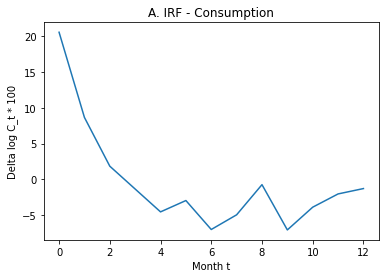

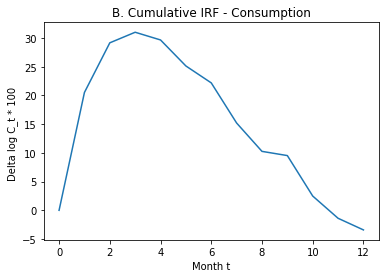

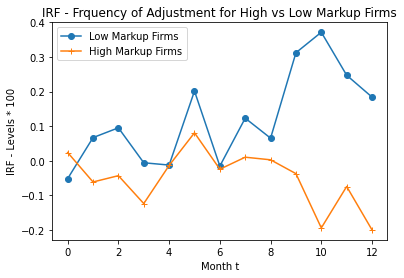

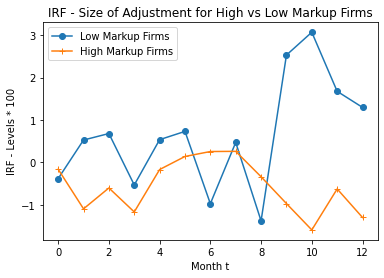

In [34]:
""" Simulate Episodes and Calculate Regressions"""

shutdown()
init(
    num_cpus=11,
    log_to_driver=False,
)
# register environment
env_label = "mon_policy_finite"
register_env(env_label, MonPolicyFinite)
# We instantiate the environment to extract information.
""" CHANGE HERE """
env_config_simul = env_config_eval.copy()
env_config_simul["random_eval"] = False
env_config_noagg = env_config_simul.copy()
env_config_noagg["no_agg"] = True
env = MonPolicyFinite(env_config_simul)
env_noagg = MonPolicyFinite(env_config_noagg)

""" Restore trainer """

# restore the trainer

trained_trainer = PPOTrainer(env=env_label, config=config_algo)
trained_trainer.restore(INPUT_PATH_CHECKPOINT)

""" Simulate an episode (SIMUL_PERIODS timesteps) """
profits_list = []
mu_ij_list = []
mu_ij_final_list = []
freq_p_adj_list = []
size_adj_list = []
freq_adj_lowmu_list = []
freq_adj_highmu_list = []
size_adj_list = []
size_adj_lowmu_list = []
size_adj_highmu_list = []

log_c_list = []
epsilon_g_list = []

profits_list_noagg = []
mu_ij_list_noagg = []
freq_p_adj_list_noagg = []
freq_adj_lowmu_list_noagg = []
freq_adj_highmu_list_noagg = []
size_adj_list_noagg = []
size_adj_lowmu_list_noagg = []
size_adj_highmu_list_noagg = []
log_c_list_noagg = []

log_c_filt_list = []
freq_adj_lowmu_filt_list = []
freq_adj_highmu_filt_list = []
size_adj_lowmu_filt_list = []
size_adj_highmu_filt_list = []

# loop with agg
obs = env.reset()
obs_noagg = env_noagg.reset()

for t in range(SIMUL_EPISODES * ENV_HORIZON):
    if t % env.horizon == 0:
        seed = random.randrange(100000)
        env.seed_eval = seed
        env_noagg.seed_eval = seed
        print("time:", t)
        obs = env.reset()
        obs_noagg = env_noagg.reset()
    action = {
        i: trained_trainer.compute_action(obs[i], policy_id=f"policy_{i%NUM_POLICY}")
        for i in range(env.n_agents)
    }
    action_noagg = {
        i: trained_trainer.compute_action(
            obs_noagg[i], policy_id=f"policy_{i%NUM_POLICY}"
        )
        for i in range(env.n_agents)
    }

    obs, rew, done, info = env.step(action)
    obs_noagg, rew_noagg, done_noagg, info_noagg = env_noagg.step(action_noagg)

    if t % env.horizon < NO_FLEX_HORIZON:
        profits_list.append(info[0]["mean_profits"])
        mu_ij_list.append(info[0]["mean_mu_ij"])
        freq_p_adj_list.append(info[0]["move_freq"])
        freq_adj_lowmu_list.append(info[0]["move_freq_lowmu"])
        freq_adj_highmu_list.append(info[0]["move_freq_highmu"])
        size_adj_list.append(info[0]["mean_p_change"])
        size_adj_lowmu_list.append(info[0]["size_adj_lowmu"])
        size_adj_highmu_list.append(info[0]["size_adj_highmu"])
        log_c_list.append(info[0]["log_c"])
        epsilon_g_list.append(env.epsilon_g)
        profits_list_noagg.append(info_noagg[0]["mean_profits"])
        mu_ij_list_noagg.append(info_noagg[0]["mean_mu_ij"])
        freq_p_adj_list_noagg.append(info_noagg[0]["move_freq"])
        freq_adj_lowmu_list_noagg.append(info_noagg[0]["move_freq_lowmu"])
        freq_adj_highmu_list_noagg.append(info_noagg[0]["move_freq_highmu"])
        size_adj_list_noagg.append(info_noagg[0]["mean_p_change"])
        size_adj_lowmu_list_noagg.append(info_noagg[0]["size_adj_lowmu"])
        size_adj_highmu_list_noagg.append(info_noagg[0]["size_adj_highmu"])
        log_c_list_noagg.append(info_noagg[0]["log_c"])
        log_c_filt_list.append(log_c_list[-1] - log_c_list_noagg[-1])
        freq_adj_lowmu_filt_list.append(
            freq_adj_lowmu_list[-1] - freq_adj_lowmu_list_noagg[-1]
        )
        freq_adj_highmu_filt_list.append(
            freq_adj_highmu_list[-1] - freq_adj_highmu_list_noagg[-1]
        )
        size_adj_lowmu_filt_list.append(
            size_adj_lowmu_list[-1] - size_adj_lowmu_list_noagg[-1]
        )
        size_adj_highmu_filt_list.append(
            size_adj_highmu_list[-1] - size_adj_highmu_list_noagg[-1]
        )
    if t % env.horizon > env.horizon - env.final_stage:
        mu_ij_final_list.append(info[0]["mean_mu_ij"])

""" STEP 4, PLOT IRS and PROCESS RESULTS"""

simul_results_dict = {
    "Mean Profits": [],
    "S.D. Profits": [],
    "Max Profits": [],
    "Min Profits": [],
    "Mean Markups": [],
    "S.D. Markups": [],
    "Max Markups": [],
    "Min Markups": [],
    "Mean Freq. of Adj.": [],
    "S.D. Freq. of Adj.": [],
    "Max Freq. of Adj.": [],
    "Min Freq. of Adj.": [],
    "Mean Size of Adj.": [],
    "S.D. Size of Adj.": [],
    "Max Size of Adj.": [],
    "Min Size of Adj.": [],
    "S.D. log C": [],
    "Mean Flex. Markup": [],
    "IRs": [],
    "cum_IRs": [],
}
epsilon_g_pereps = [
    epsilon_g_list[i * NO_FLEX_HORIZON : i * NO_FLEX_HORIZON + NO_FLEX_HORIZON]
    for i in range(SIMUL_EPISODES)
]
log_c_filt_pereps = [
    log_c_filt_list[i * NO_FLEX_HORIZON : i * NO_FLEX_HORIZON + NO_FLEX_HORIZON]
    for i in range(SIMUL_EPISODES)
]
freq_adj_lowmu_pereps = [
    freq_adj_lowmu_filt_list[
        i * NO_FLEX_HORIZON : i * NO_FLEX_HORIZON + NO_FLEX_HORIZON
    ]
    for i in range(SIMUL_EPISODES)
]
freq_adj_highmu_pereps = [
    freq_adj_highmu_filt_list[
        i * NO_FLEX_HORIZON : i * NO_FLEX_HORIZON + NO_FLEX_HORIZON
    ]
    for i in range(SIMUL_EPISODES)
]
size_adj_lowmu_pereps = [
    size_adj_lowmu_filt_list[
        i * NO_FLEX_HORIZON : i * NO_FLEX_HORIZON + NO_FLEX_HORIZON
    ]
    for i in range(SIMUL_EPISODES)
]
size_adj_highmu_pereps = [
    size_adj_highmu_filt_list[
        i * NO_FLEX_HORIZON : i * NO_FLEX_HORIZON + NO_FLEX_HORIZON
    ]
    for i in range(SIMUL_EPISODES)
]
delta_log_c_pereps = [
    [j - i for i, j in zip(log_c_filt_pereps[k][:-1], log_c_filt_pereps[k][1:])]
    for k in range(SIMUL_EPISODES)
]
# print("log_c_filt:", log_c_filt_list, "\n",
#     #"delta_log_c:", delta_log_c,
#     "\n"
print(
    "corr betweeen cons:",
    np.corrcoef(log_c_list, log_c_list_noagg),
)
plt.plot(log_c_filt_list)
plt.title("A. Log C filtered")
# plt.show()
plt.close()

IRs = [0 for t in range(13)]
IRs_freqlow = [0 for t in range(13)]
IRs_freqhigh = [0 for t in range(13)]
IRs_sizelow = [0 for t in range(13)]
IRs_sizehigh = [0 for t in range(13)]
for t in range(0, 13):
    epsilon_g_pereps_reg = [
        epsilon_g_pereps[i][: -(t + 1)] for i in range(SIMUL_EPISODES)
    ]
    delta_log_c_pereps_reg = [delta_log_c_pereps[i][t:] for i in range(SIMUL_EPISODES)]
    freq_adj_lowmu_pereps_reg = [
        freq_adj_lowmu_pereps[i][t:] for i in range(SIMUL_EPISODES)
    ]
    freq_adj_highmu_pereps_reg = [
        freq_adj_highmu_pereps[i][t:] for i in range(SIMUL_EPISODES)
    ]
    size_adj_lowmu_pereps_reg = [
        size_adj_lowmu_pereps[i][t:] for i in range(SIMUL_EPISODES)
    ]
    size_adj_highmu_pereps_reg = [
        size_adj_highmu_pereps[i][t:] for i in range(SIMUL_EPISODES)
    ]
    epsilon_g_reg = [item for sublist in epsilon_g_pereps_reg for item in sublist]
    delta_log_c_reg = [item for sublist in delta_log_c_pereps_reg for item in sublist]
    freq_adj_lowmu_reg = [
        item for sublist in freq_adj_lowmu_pereps_reg for item in sublist
    ]
    freq_adj_highmu_reg = [
        item for sublist in freq_adj_highmu_pereps_reg for item in sublist
    ]
    size_adj_lowmu_reg = [
        item for sublist in size_adj_lowmu_pereps_reg for item in sublist
    ]
    size_adj_highmu_reg = [
        item for sublist in size_adj_highmu_pereps_reg for item in sublist
    ]

    epsilon_g_reg_filt = [i for i in epsilon_g_reg if i > 0]
    delta_log_c_reg_filt = [
        delta_log_c_reg[i] for i in range(len(epsilon_g_reg)) if epsilon_g_reg[i] > 0
    ]
    freq_adj_lowmu_reg_filt = [
        freq_adj_lowmu_reg[i] for i in range(len(epsilon_g_reg)) if epsilon_g_reg[i] > 0
    ]
    freq_adj_highmu_reg_filt = [
        freq_adj_highmu_reg[i]
        for i in range(len(epsilon_g_reg))
        if epsilon_g_reg[i] > 0
    ]
    size_adj_lowmu_reg_filt = [
        size_adj_lowmu_reg[i] for i in range(len(epsilon_g_reg)) if epsilon_g_reg[i] > 0
    ]
    size_adj_highmu_reg_filt = [
        size_adj_highmu_reg[i]
        for i in range(len(epsilon_g_reg))
        if epsilon_g_reg[i] > 0
    ]
    # epsilon_g_reg_filt = [i for i in epsilon_g_reg if i>0.007]
    # delta_log_c_reg_filt = [delta_log_c_reg[i] for i in range(len(epsilon_g_reg)) if epsilon_g_reg[i]>0.007]
    # freq_adj_lowmu_reg_filt = [freq_adj_lowmu_reg[i] for i in range(len(epsilon_g_reg)) if epsilon_g_reg[i]>0.007]
    # freq_adj_highmu_reg_filt = [freq_adj_highmu_reg[i] for i in range(len(epsilon_g_reg)) if epsilon_g_reg[i]>0.007]
    # size_adj_lowmu_reg_filt = [size_adj_lowmu_reg[i] for i in range(len(epsilon_g_reg)) if epsilon_g_reg[i]>0.007]
    # size_adj_highmu_reg_filt = [size_adj_highmu_reg[i] for i in range(len(epsilon_g_reg)) if epsilon_g_reg[i]>0.007]

    # regressions
    reg_c = linregress(delta_log_c_reg, epsilon_g_reg)
    IRs[t] = reg_c[0] * env.params["sigma_g"] * 100
    reg_freqlow = linregress(freq_adj_lowmu_reg_filt, epsilon_g_reg_filt)
    IRs_freqlow[t] = reg_freqlow[0] * env.params["sigma_g"] * 100
    reg_freqhigh = linregress(freq_adj_highmu_reg_filt, epsilon_g_reg_filt)
    IRs_freqhigh[t] = reg_freqhigh[0] * env.params["sigma_g"] * 100
    reg_sizelow = linregress(size_adj_lowmu_reg_filt, epsilon_g_reg_filt)
    IRs_sizelow[t] = reg_sizelow[0] * env.params["sigma_g"] * 100
    reg_sizehigh = linregress(size_adj_highmu_reg_filt, epsilon_g_reg_filt)
    IRs_sizehigh[t] = reg_sizehigh[0] * env.params["sigma_g"] * 100
cum_IRs = [np.sum(IRs[:t]) for t in range(13)]
cum_IRs_freqlow = [np.sum(IRs_freqlow[:t]) for t in range(13)]
cum_IRs_freqhigh = [np.sum(IRs_freqhigh[:t]) for t in range(13)]
cum_IRs_sizelow = [np.sum(IRs_sizelow[:t]) for t in range(13)]
cum_IRs_sizehigh = [np.sum(IRs_sizehigh[:t]) for t in range(13)]

print(
    "cum_IRs_freqlow:",
    cum_IRs_freqlow[3],
    "\n",
    "cum_IRs_freqhigh:",
    cum_IRs_freqhigh[3],
    "\n",
    "cum_IRs_sizelow:",
    cum_IRs_sizelow[3],
    "\n",
    "cum_IRs_sizehigh:",
    cum_IRs_sizehigh[3],
    "\n",
)

simul_results_dict["Mean Profits"].append(np.mean(profits_list))
simul_results_dict["S.D. Profits"].append(np.std(profits_list))
simul_results_dict["Max Profits"].append(np.max(profits_list))
simul_results_dict["Min Profits"].append(np.min(profits_list))
simul_results_dict["Mean Markups"].append(np.mean(mu_ij_list))
simul_results_dict["S.D. Markups"].append(np.std(mu_ij_list))
simul_results_dict["Max Markups"].append(np.max(mu_ij_list))
simul_results_dict["Min Markups"].append(np.min(mu_ij_list))
simul_results_dict["Mean Freq. of Adj."].append(np.mean(freq_p_adj_list))
simul_results_dict["S.D. Freq. of Adj."].append(np.std(freq_p_adj_list))
simul_results_dict["Max Freq. of Adj."].append(np.max(freq_p_adj_list))
simul_results_dict["Min Freq. of Adj."].append(np.min(freq_p_adj_list))
simul_results_dict["Mean Size of Adj."].append(np.mean(size_adj_list))
simul_results_dict["S.D. Size of Adj."].append(np.std(size_adj_list))
simul_results_dict["Max Size of Adj."].append(np.max(size_adj_list))
simul_results_dict["Min Size of Adj."].append(np.min(size_adj_list))
simul_results_dict["S.D. log C"].append(np.std(log_c_filt_list))
simul_results_dict["Mean Flex. Markup"].append(np.mean(mu_ij_final_list))
simul_results_dict["IRs"].append(IRs)
simul_results_dict["cum_IRs"].append(cum_IRs)
# simul_results_dict["IRs_freqlow"].append(IRs_freqlow)
# simul_results_dict["IRs_freqhigh"].append(IRs_freqhigh)
# simul_results_dict["IRs_sizelow"].append(IRs_sizelow)
# simul_results_dict["IRs_sizehigh"].append(IRs_sizehigh)

print("Simul_results_dict:", simul_results_dict)
# print(
#     "std_log_c:",
#     simul_results_dict["S.D. log C"],
#     "\n" + "mu_ij:",
#     simul_results_dict["Mean Markups"],
#     "\n" + "freq_p_adj:",
#     simul_results_dict["Mean Freq. of Adj."],
#     "\n" + "size_adj:",
#     simul_results_dict["Mean Size of Adj."],
#     "\n" + "mu_ij_final:",
#     simul_results_dict["Mean Flex. Markup"],
# )

""" Plot IRs """
x = [i for i in range(13)]
IRs = simul_results_dict["IRs"][-1]
plt.plot(x, IRs)
# learning_plot = learning_plot.get_figure()
plt.ylabel("Delta log C_t * 100")
plt.xlabel("Month t")
plt.title("A. IRF - Consumption")
plt.savefig(OUTPUT_PATH_FIGURES + "IRs_" + exp_names[0] + ".png")
plt.show()
plt.close()

cum_IRs = simul_results_dict["cum_IRs"][-1]
plt.plot(x, cum_IRs)
# learning_plot = learning_plot.get_figure()
plt.ylabel("Delta log C_t * 100 ")
plt.xlabel("Month t")
plt.title("B. Cumulative IRF - Consumption")
plt.savefig(OUTPUT_PATH_FIGURES + "cum_IRs_" + exp_names[0] + ".png")
plt.show()
plt.close()

plt.plot(x, IRs_freqlow, "-o")
plt.plot(x, IRs_freqhigh, "-+")
plt.legend(["Low Markup Firms", "High Markup Firms"])
# learning_plot = learning_plot.get_figure()
plt.ylabel("IRF - Levels * 100")
plt.xlabel("Month t")
plt.title("IRF - Frquency of Adjustment for High vs Low Markup Firms")
plt.savefig(OUTPUT_PATH_FIGURES + "IRs_freq_" + exp_names[0] + ".png")
plt.show()
plt.close()

plt.plot(x, IRs_sizelow, "-o")
plt.plot(x, IRs_sizehigh, "-+")
plt.legend(["Low Markup Firms", "High Markup Firms"])
# learning_plot = learning_plot.get_figure()
plt.ylabel("IRF - Levels * 100")
plt.xlabel("Month t")
plt.title("IRF - Size of Adjustment for High vs Low Markup Firms")
plt.savefig(OUTPUT_PATH_FIGURES + "IRs_size_" + exp_names[0] + ".png")
plt.show()
plt.close()